In [40]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from time import time
import matplotlib as plt

sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.ToTensor(),
    download = True,
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.ToTensor()
)

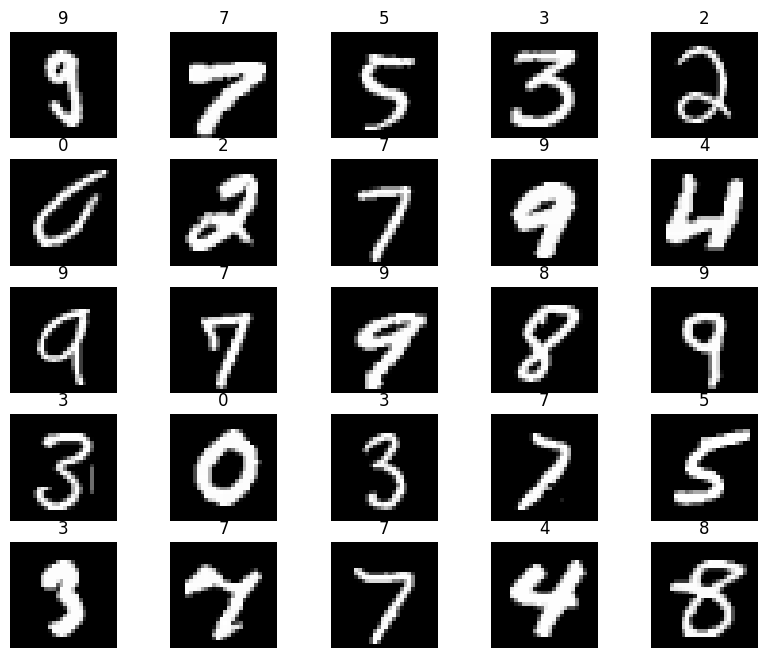

In [42]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [43]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}

In [44]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

        pass

In [45]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [46]:
def train(num_epochs, model, loaders):

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass


        pass
    pass
train(num_epochs, model, loaders)

Epoch [1/2], Step [100/600], Loss: 0.6639
Epoch [1/2], Step [200/600], Loss: 0.2406
Epoch [1/2], Step [300/600], Loss: 0.2129
Epoch [1/2], Step [400/600], Loss: 0.1855
Epoch [1/2], Step [500/600], Loss: 0.1034
Epoch [1/2], Step [600/600], Loss: 0.1653
Epoch [2/2], Step [100/600], Loss: 0.0975
Epoch [2/2], Step [200/600], Loss: 0.0362
Epoch [2/2], Step [300/600], Loss: 0.1338
Epoch [2/2], Step [400/600], Loss: 0.1265
Epoch [2/2], Step [500/600], Loss: 0.0355
Epoch [2/2], Step [600/600], Loss: 0.1371


In [47]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 97.84 %


In [48]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

test_output = model(imgs[:30].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy().squeeze()
labels = lbls[:30].numpy()
print(f"Predicted number:   {predicted}")
print(f"Actual number:      {labels}")

Predicted number:   [4 8 9 7 0 7 0 7 8 7 0 9 6 0 8 2 6 5 1 8 6 3 3 3 1 5 1 5 2 3]
Actual number:      [4 8 4 7 0 7 0 7 8 3 0 9 6 0 8 2 6 5 1 8 6 1 3 3 1 5 1 5 2 3]
